# Ostateczne Modelowanie

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import re
import string
import nltk
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn import feature_extraction
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')
# wczytanie ramki danych ze zliczonymi wystąpieniami słów
df = pd.read_csv('AsianReligionsData/AllBooks_baseline_DTM_Labelled.csv')

## Utworzenie nowych cech:
- liczba słów w rozdziale,
- średnia długość słowa w rozdziale (w literach),
- liczba zdań w rozdziale,
- średnia długość zdania w rozdziale (w słowach).

In [2]:
# wczytanie tekstów
with open('AsianReligionsData/Complete_data.txt', 'r',encoding='latin-1') as file:
    text = file.read()
text = re.split(r'\n\d\.\d+\n', text)
text = [re.sub(r'\d\.\d+\n','',i) for i in text]

# podział na słowa
word = re.compile(r'\b([A-Za-z]+)\b')
words = list(map(word.findall, text))

# podział na zdania
sentence = re.compile(r'\b([A-Z].*?[.!?]+)[\b\s\W]')
sentences = list(map(sentence.findall, text))

# obliczenie pewnych statystyk
n_words = [len(x) for x in words] # liczba słów w rozdziale
mean_word_len = [np.mean(list(map(len, x))) for x in words] # średnia długość słowa w rozdziale (w literach)
n_sentences = [len(x) for x in sentences] # liczba zdań w rozdziale
mean_sentence_len = [np.mean(list(map(lambda x:len(word.findall(x)), x))) for x in sentences] # średnia długość zdania w rozdziale (w słowach)

# poprawki
mean_word_len[13] = 0.0
mean_sentence_len[13] = 0.0
n_sentences[145] = 1
mean_sentence_len[145] = float(len(word.findall(text[145])))

# dodanie do ramki danych
df['n_words'] = n_words
df['mean_word_len'] = mean_word_len
df['n_sentences'] = n_sentences
df['mean_sentence_len'] = mean_sentence_len

## Podział ksiąg na dwie grupy:
- księgi chrześcijańskie,
- księgi niechrześcijańskie.

In [3]:
p = r'[A-Za-z]+'
book = re.compile(p)
books = list(map(lambda x: book.match(x).group(), df[df.columns[0]]))
df['book_name'] = books

le = preprocessing.LabelEncoder()
df['book_name'] = le.fit_transform(df['book_name'])

book_groups = {'BookOfEccleasiasticus':0,
 'BookOfEcclesiastes':0,
 'BookOfProverb':0,
 'BookOfWisdom':0,
 'Buddhism':1,
 'TaoTeChing':1,
 'Upanishad':1,
 'YogaSutra':1}

gbooks = books.copy()
for i in range(len(books)):
    gbooks[i] = book_groups[books[i]]

## Oryginalny podział na osiem ksiąg

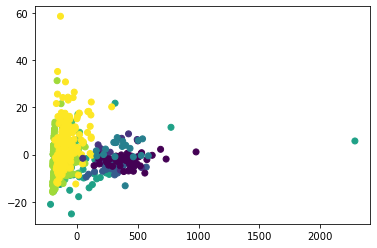

In [4]:
X = df[df.columns[-5:-1]]
pca = PCA(n_components=2)
X = pca.fit_transform(X)
plt.scatter(pd.DataFrame(X)[0],pd.DataFrame(X)[1], c=df['book_name'])
plt.show()

## Przetestowanie metod klasteryzujących

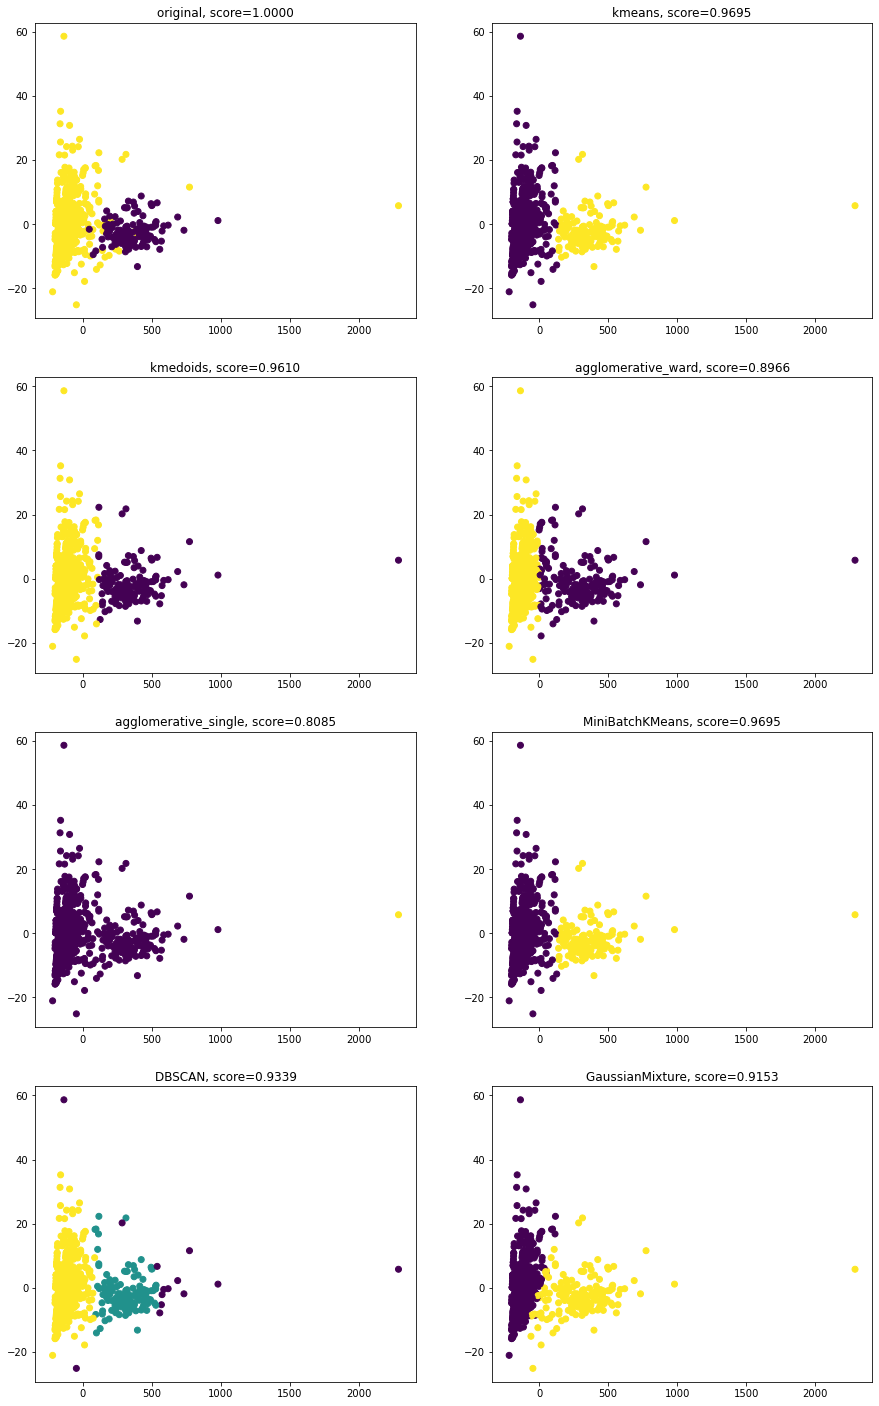

In [5]:
X = df[df.columns[-5:-1]]
n_clusters = 2

models = []

models.append(KMeans(n_clusters=n_clusters, random_state=0))
models.append(KMedoids(n_clusters=n_clusters, random_state=0))
models.append(AgglomerativeClustering(n_clusters=n_clusters, linkage = 'ward'))
models.append(AgglomerativeClustering(n_clusters=n_clusters, linkage = 'single'))
models.append(MiniBatchKMeans(n_clusters=n_clusters))
models.append(DBSCAN(eps=22, min_samples=8))
models.append(GaussianMixture(n_components=n_clusters, covariance_type='diag'))

labels = [gbooks]

for model in models:
    labels.append(model.fit_predict(X))
    
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_df = pd.DataFrame(X_pca)

scores = []
for label in labels:
    a = sum(np.array(gbooks)==label)/len(gbooks)
    scores.append(a if a > 0.5 else 1-a)
    
((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.figure(figsize=(15,25)).subplots(4,2)
plots = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

for i,plot in enumerate(plots):
    plot.scatter(X_df[0], X_df[1], c = labels[i])
    
ax1.set_title(f'original, score={scores[0]:.4f}')
ax2.set_title(f'kmeans, score={scores[1]:.4f}')
ax3.set_title(f'kmedoids, score={scores[2]:.4f}')
ax4.set_title(f'agglomerative_ward, score={scores[3]:.4f}')
ax5.set_title(f'agglomerative_single, score={scores[4]:.4f}')
ax6.set_title(f'MiniBatchKMeans, score={scores[5]:.4f}')
ax7.set_title(f'DBSCAN, score={scores[6]:.4f}')
ax8.set_title(f'GaussianMixture, score={scores[7]:.4f}')

plt.show()

In [6]:
from nltk.stem.snowball import SnowballStemmer
with open('AsianReligionsData/Complete_data.txt', 'r', encoding='latin-1') as file:
    texts = file.read()
texts = re.split(r'\n\d\.\d+\n', texts)
texts = [re.sub(r'\d\.\d+\n','',i) for i in texts]
stopwords = nltk.corpus.stopwords.words('english')
stemmer = SnowballStemmer("english")

In [7]:
def tokenize_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            token = token.translate(str.maketrans('', '', '.,1234567890§'))
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [8]:
def tokenize(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            token = token.translate(str.maketrans('', '', '.,1234567890§'))
            filtered_tokens.append(token)
    return filtered_tokens

In [9]:
totalvocab_stemmed = []
for i in texts:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
totalvocab_stemmed = list(dict.fromkeys(totalvocab_stemmed))

totalvocab_tokenized = []
for i in texts:
    allwords_tokenized = tokenize(i)
    totalvocab_tokenized.extend(allwords_tokenized)
totalvocab_tokenized = list(dict.fromkeys(totalvocab_tokenized))

In [10]:
print(len(totalvocab_stemmed))
print(len(totalvocab_tokenized))

5548
8425


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer_tok = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.05, stop_words='english',
                                 use_idf=True, tokenizer=tokenize, ngram_range=(1,3))

tfidf_matrix_tok = tfidf_vectorizer_tok.fit_transform(texts)
print(tfidf_matrix_tok.shape)

(590, 197)


In [12]:
tfidf_vectorizer_stem = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.05, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

tfidf_matrix_stem = tfidf_vectorizer_stem.fit_transform(texts)
print(tfidf_matrix_stem.shape)

(590, 262)


In [13]:
from sklearn.cluster import KMeans

num_clusters = 4
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix_stem)
clusters = km.labels_.tolist()

In [14]:
num_clusters = 4
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix_tok)
clusters_tok = km.labels_.tolist()

In [15]:
frame = pd.read_csv('AsianReligionsData/AllBooks_baseline_DTM_Labelled.csv')
titles = list(frame[frame.columns[0]])
AllBooks = {"title":titles, "text":texts, "cluster":clusters}
AllBooksFrame = pd.DataFrame(AllBooks, index = [titles], columns = ["title", "cluster", "text"])

In [16]:
frame = pd.read_csv('AsianReligionsData/AllBooks_baseline_DTM_Labelled.csv')
AllBooks_tok = {"title":titles, "text":texts, "cluster":clusters_tok}
AllBooksFrame_tok = pd.DataFrame(AllBooks, index = [titles], columns = ["title", "cluster", "text"])

In [17]:
from sklearn.manifold import TSNE
tSNE = TSNE(n_components = 2, random_state=42, verbose=1)
digits_proj = tSNE.fit_transform(tfidf_matrix_stem)
digits_proj_tok = tSNE.fit_transform(tfidf_matrix_tok)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 590 samples in 0.001s...
[t-SNE] Computed neighbors for 590 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 590 / 590
[t-SNE] Mean sigma: 0.392845
[t-SNE] KL divergence after 250 iterations with early exaggeration: 97.444656
[t-SNE] KL divergence after 1000 iterations: 1.582393
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 590 samples in 0.000s...
[t-SNE] Computed neighbors for 590 samples in 0.020s...
[t-SNE] Computed conditional probabilities for sample 590 / 590
[t-SNE] Mean sigma: 0.403148
[t-SNE] KL divergence after 250 iterations with early exaggeration: 97.505318
[t-SNE] KL divergence after 1000 iterations: 1.460325


In [18]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix_stem)

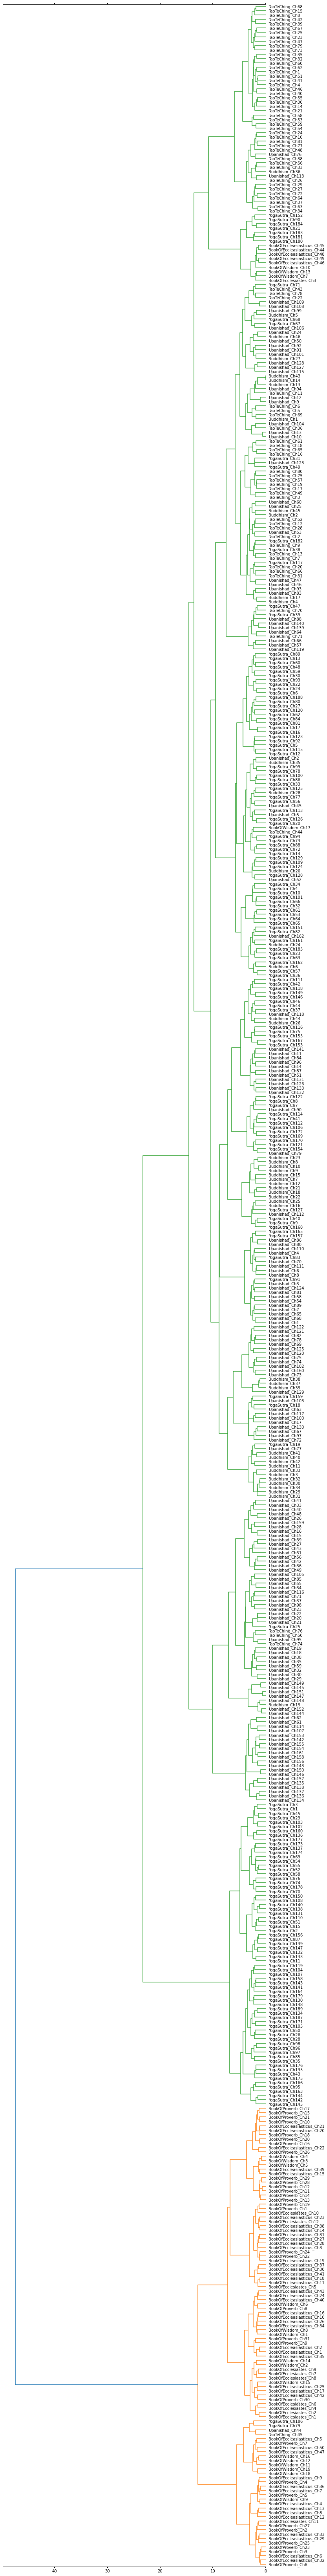

In [19]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) 

fig, ax = plt.subplots(figsize=(12, 120)) # set size
ax = dendrogram(linkage_matrix, orientation="left", labels=titles, leaf_font_size = 10);

plt.tick_params(\
    axis= 'x',         
    which='both',    
    bottom='off',      
    top='off',      
    labelbottom='off',
    width=2)

plt.show()

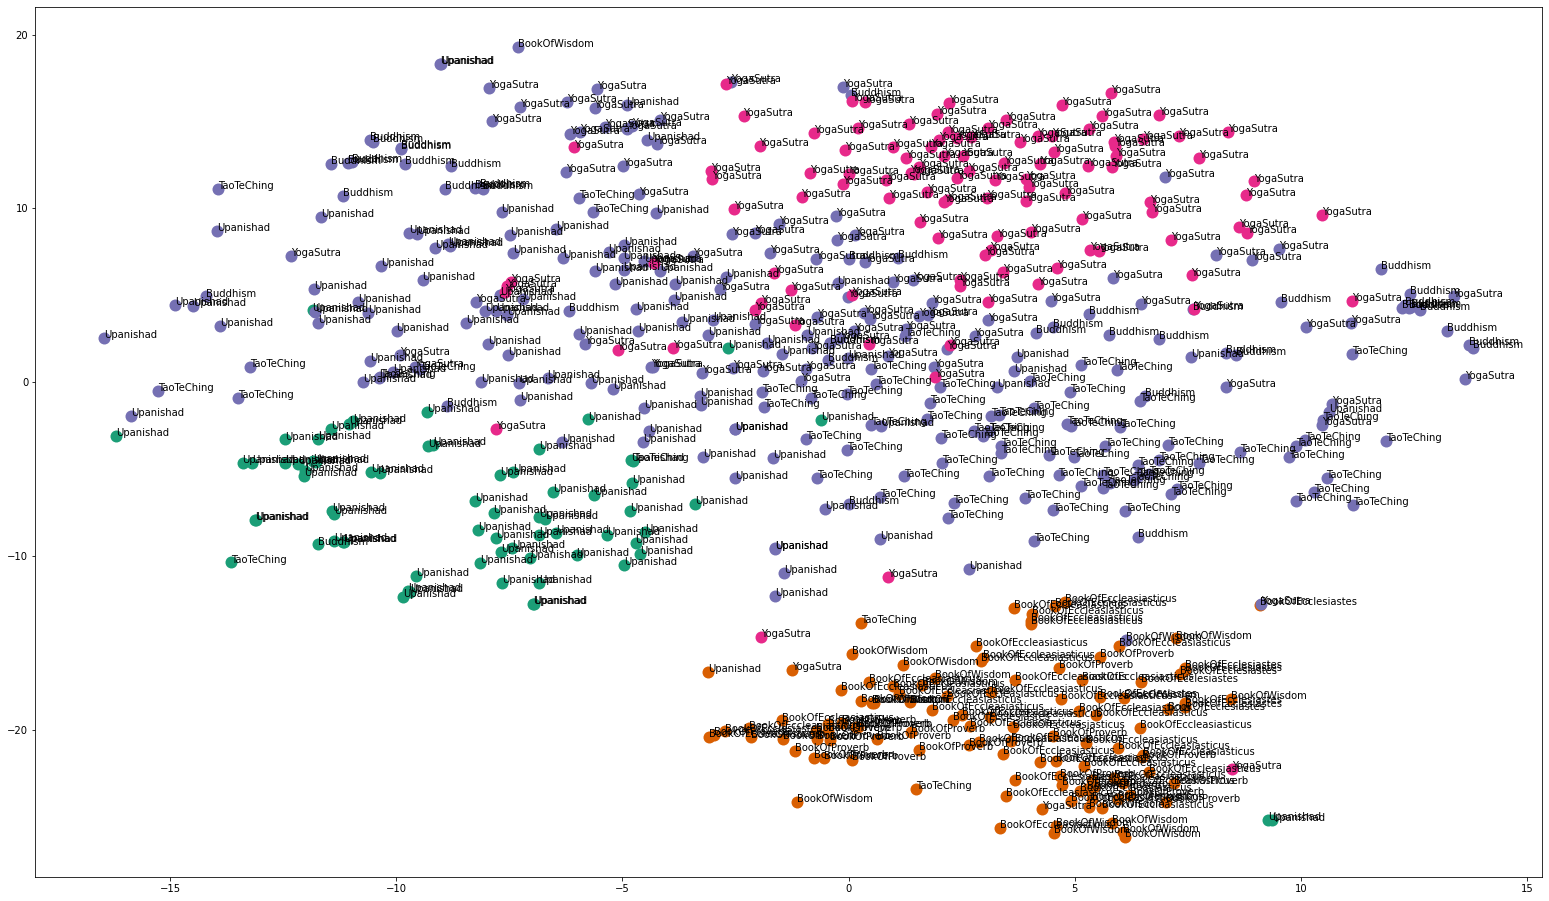

In [27]:
titles_simple =[]
for title in titles:
        title_simple = title.split("_")[0]
        titles_simple.append(title_simple)
df = pd.DataFrame(dict(x=digits_proj[:,0], y=digits_proj[:,1], label=clusters, title=titles_simple))
groups = df.groupby('label')
fig, ax = plt.subplots(figsize=(27, 16))
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a'}
cluster_names = {1: '1', 
                 2: '2', 
                 3: '3', 
                 4: '4'}
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=clusters, color=cluster_colors[name], 
            mec='none')
for i in range(len(df)):
    ax.text(df.iloc[i,0], df.iloc[i,1], df.iloc[i,3], size=10)  


plt.show()

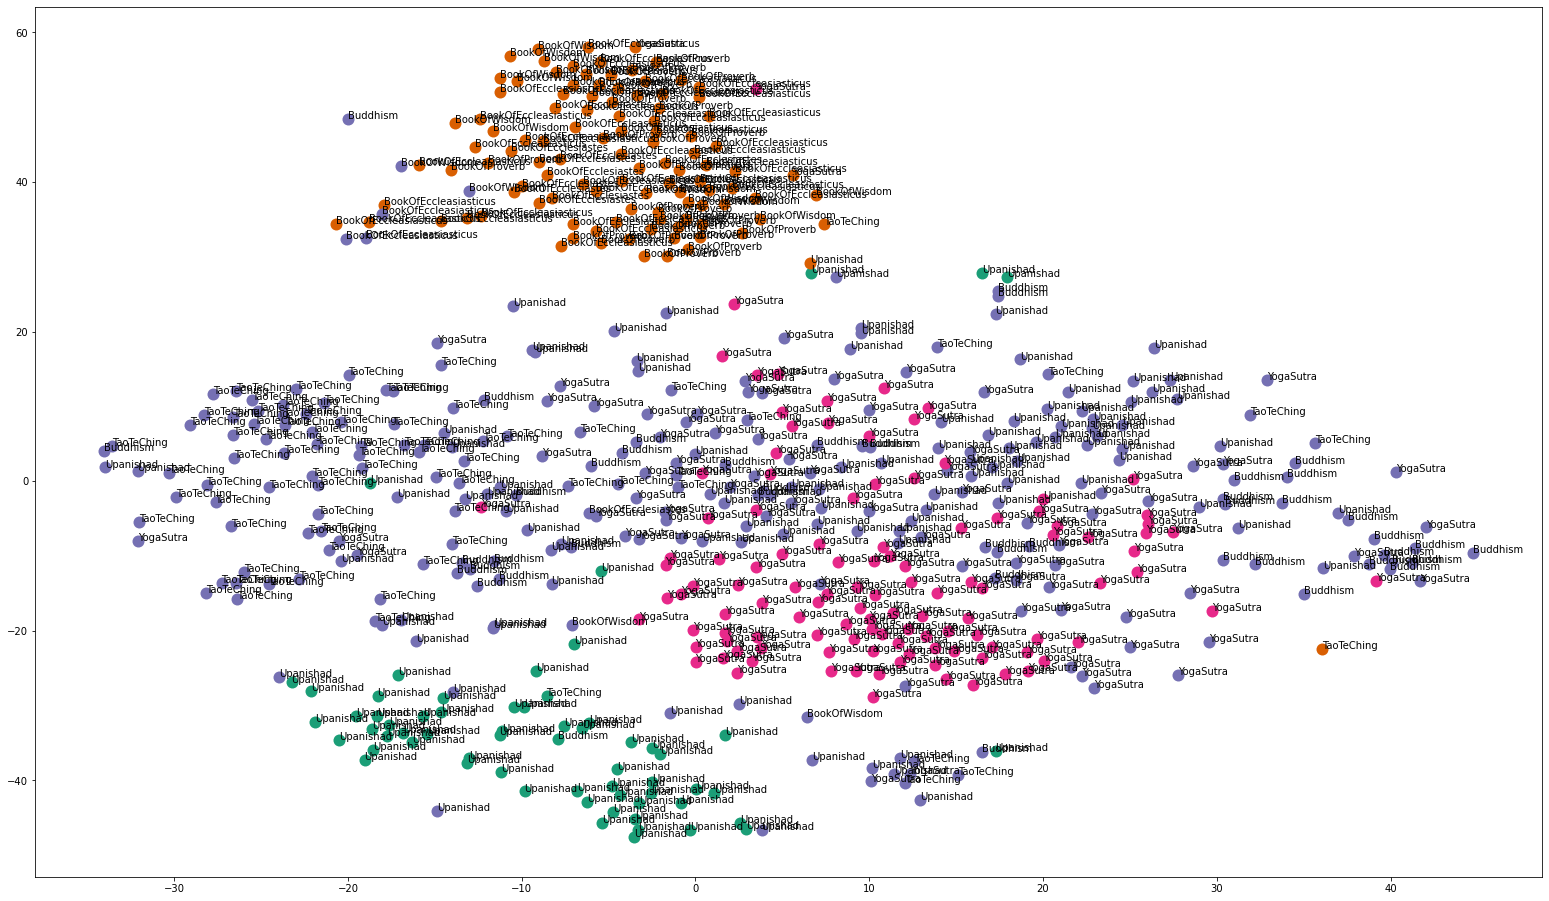

In [28]:
titles_simple =[]
for title in titles:
        title_simple = title.split("_")[0]
        titles_simple.append(title_simple)
df = pd.DataFrame(dict(x=digits_proj_tok[:,0], y=digits_proj_tok[:,1], label=clusters_tok, title=titles_simple))
groups = df.groupby('label')
fig, ax = plt.subplots(figsize=(27, 16))
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a'}
cluster_names = {1: '1', 
                 2: '2', 
                 3: '3', 
                 4: '4'}
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=clusters_tok, color=cluster_colors[name], 
            mec='none')
for i in range(len(df)):
    ax.text(df.iloc[i,0], df.iloc[i,1], df.iloc[i,3], size=10)  


plt.show()